# FDA HW3: Stock Price Movement Prediction

## Description
In this assignment I will predict the stock price movement by trying 3 machine learning methods: **Logistic Regression**, **Support Vector Machine** and **Neural Network**. I will also compare the results of these methods, and discuss the differences and the limits when predict stock price movement.

## Dataset
S&P500 stock dataset, downloaded from [here](https://www.sharecast.com/index/SP_500/prices/download).
* Training set: 2009/1/20 ~ 2017/12/29
* Test set: 2018/1/2 ~ 2018/12/31

The main purpose of this assignment is to practice machine learning methods on real world stock movement prediction. In order to simplify the process and increase the reality, I decided to download a larger dataset so as to generate more complete infromation for the training. That is, I will download a dataset with more dates before and after the time peroid mentioned above, and drop the extra part after data preprocessing.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection
from sklearn.metrics import median_absolute_error, mean_squared_error, confusion_matrix
from sklearn.preprocessing import StandardScaler
from keras import models, layers, optimizers, regularizers

Using TensorFlow backend.


In [2]:
data_train = pd.read_csv('./data/train.csv')
data_test = pd.read_csv('./data/test.csv')
data_test2 = pd.read_csv('./data/test2.csv')

In [3]:
data_train.tail(11)

,Date,Open Price,Close Price,High Price,Low Price,Volume
2263,29-Dec-2017,2689.15,2673.61,2692.12,2673.61,1332374016
2264,02-Jan-2018,2683.73,2695.81,2695.89,2682.36,1846463232
2265,03-Jan-2018,2697.85,2713.06,2714.37,2697.77,2090595328
2266,04-Jan-2018,2719.31,2723.99,2729.29,2719.07,2100767744
2267,05-Jan-2018,2731.33,2743.15,2743.45,2727.92,1918869120
2268,08-Jan-2018,2742.67,2747.71,2748.51,2737.60,1894823936
2269,09-Jan-2018,2751.15,2751.29,2759.14,2747.86,1957263872
2270,10-Jan-2018,2745.55,2748.23,2750.80,2736.06,2048867328
2271,11-Jan-2018,2752.97,2767.56,2767.56,2752.78,1978592384
2272,12-Jan-2018,2770.18,2786.24,2787.85,2769.64,2108422912


In [4]:
data_train.dtypes

Date            object
Open Price     float64
Close Price    float64
High Price     float64
Low Price      float64
Volume           int64
dtype: object

In [5]:
print(data_train.shape, data_test.shape)

(2274, 6) (508, 6)


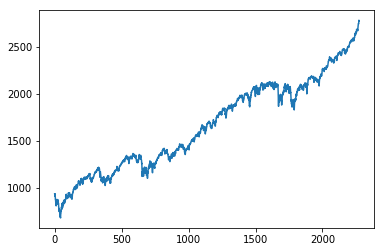

In [6]:
plt.plot(data_train['Close Price'])

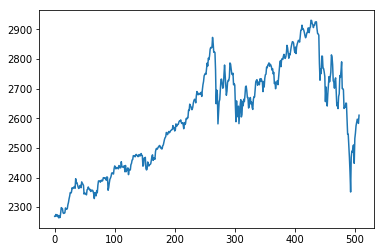

In [7]:
plt.plot(data_test['Close Price'])

In [8]:
# plt.plot(data_test2['Close Price'])

## Data Preprocessing

### Stock Movement (Returns for the future 10 days)
Our goal is to predict the stock price movement, so here I create a **returns** value, indicating the extent to which the stock price moving up or down in the following 10 days. (The reason why I choose 10 for prediction is that 10 days is a medium term time peroid, which is harder than predicting short term movement and esier than predicting long term movement.)

In [9]:
def Next10Retruns(df):
    returnsNext10 = (df['Close Price'].shift(-10)-df['Close Price']) / df['Close Price']
    binary_target = (returnsNext10 >= 0).astype('int8')
    return returnsNext10, binary_target

def Next1Retruns(df):
    returnsNext1 = (df['Close Price'].shift(-1)-df['Close Price']) / df['Close Price']
    binary_target = (returnsNext1 >= 0).astype('int8')
    return returnsNext1, binary_target

y_train_num, y_train = Next10Retruns(data_train)
# y_train_num, y_train = Next1Retruns(data_train)
y_train_num = y_train_num[y_train_num.index <= 2263] # the number 2263 row is the date of 2017/12/29
y_train_num = y_train_num[26 <= y_train_num.index]
y_train = y_train[y_train.index <= 2263]
y_train = y_train[26 <= y_train.index]
# y_train_num

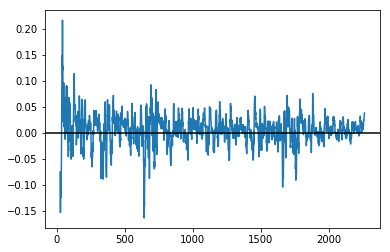

In [10]:
plt.plot(y_train_num)
plt.axhline(0, color= 'black')

In [11]:
print(len(y_train[y_train == 1]), len(y_train[y_train == 0]))
# print('proportion of rising %f' % len(y_train[y_train == 1])/len(y_train))

1429 809


### Feature Generation
* Create Returns: 1 days and 10 days
* Create Lags
* Some techinical analysis indexes

#### 1.Create Returns

In [12]:
def PreReturns(df):
    df['returnsPre10'] = (df['Close Price']-df['Close Price'].shift(10)) / df['Close Price'].shift(10)
    df['returnsPre1'] = (df['Close Price']-df['Close Price'].shift(1)) / df['Close Price'].shift(1)
    return df

data_train = PreReturns(data_train)
# data_train.head(20)

#### 2.Create Lags
Create lags for **Open Price**, **Close Price**, **returnsPre10** and **returnsPre1** with 3, 7, and 14 days.

In [13]:
# def create_lags(df, features_to_lags, n_lag=[3,5,10], shift_size=1):
#     for col in features_to_lags:
#         for window in n_lag:
#             rolled = df[col].shift(shift_size).rolling(window=window)
#             lag_mean = rolled.mean()
#             lag_max = rolled.max()
#             lag_min = rolled.min()
#             df['%s_lag_%s_mean'%(col,window)] = lag_mean
#             df['%s_lag_%s_max'%(col,window)] = lag_max
#             df['%s_lag_%s_min'%(col,window)] = lag_min
#     return df

# # features_to_lags = ['Open Price', 'Close Price', 'returnsPre10', 'returnsPre1']
# features_to_lags = ['returnsPre10']
# # features_to_lags = ['returnsPre1']
# data_train = create_lags(data_train, features_to_lags)

In [14]:
def create_lags(data, features_to_lags):
    for i in range(1, 10):
        for col in features_to_lags:
            data["lag_{}".format(i)] = data[col].shift(i)
    return data

features_to_lags = ['returnsPre10']
data_train = create_lags(data_train, features_to_lags)

#### 3.Some Index of  Technical Analysis
* MACD
* RSI

In [15]:
import math
def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = (up/down) if down != 0 else math.inf
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter
        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n
        rs = up/down  if down != 0 else math.inf
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

In [16]:
# Create MACD and RSI index
def createIndex(df):
    ewma = pd.Series.ewm
    df['close_26EMA'] = ewma(df["Close Price"], span=26).mean()
    df['close_12EMA'] = ewma(df["Close Price"], span=12).mean()
    df['MACD'] = df['close_12EMA'] - df['close_26EMA']
    df['rsi_14'] = rsiFunc(df['Close Price'].values, 14)
    df['rsi_6'] = rsiFunc(df['Close Price'].values, 6)
    df = df.drop(['close_26EMA', 'close_12EMA'], axis=1)
    return df

data_train = createIndex(data_train)
# data_train.loc[:20, ['MACD', 'rsi_14', 'rsi_6']]

In [17]:
data_train = data_train[data_train.index <= 2263]
data_train = data_train[26 <= data_train.index]
data_train = data_train.drop(['Date', 'High Price', 'Low Price'], axis=1)
data_train = data_train.fillna(0)
data_train.head(20)

,Open Price,Close Price,Volume,returnsPre10,returnsPre1,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,MACD,rsi_14,rsi_6
26,866.87,827.16,6770169856,-0.021934,-0.049121,0.039829,0.044053,0.022175,-0.009533,0.041343,-0.029031,-0.021168,0.002991,0.002638,-3.721304,39.270677,38.876991
27,827.41,833.74,5926459904,-0.046162,0.007955,-0.021934,0.039829,0.044053,0.022175,-0.009533,0.041343,-0.029031,-0.021168,0.002991,-4.287093,41.137371,43.083591
28,829.91,835.19,6476460032,-0.011773,0.001739,-0.046162,-0.021934,0.039829,0.044053,0.022175,-0.009533,0.041343,-0.029031,-0.021168,-4.574159,41.563641,44.100904
29,833.95,826.84,5296650240,0.001162,-0.009998,-0.011773,-0.046162,-0.021934,0.039829,0.044053,0.022175,-0.009533,0.041343,-0.029031,-5.351632,39.777225,39.252645
30,818.61,789.17,5907820032,-0.043940,-0.045559,0.001162,-0.011773,-0.046162,-0.021934,0.039829,0.044053,0.022175,-0.009533,0.041343,-8.651936,32.905950,24.607448
31,791.06,788.42,5740709888,-0.059737,-0.000950,-0.043940,0.001162,-0.011773,-0.046162,-0.021934,0.039829,0.044053,0.022175,-0.009533,-11.185732,32.784521,24.390035
32,787.91,778.94,5746939904,-0.064033,-0.012024,-0.059737,-0.043940,0.001162,-0.011773,-0.046162,-0.021934,0.039829,0.044053,0.022175,-13.738970,31.216460,21.507718
33,775.87,770.05,8210590208,-0.089614,-0.011413,-0.064033,-0.059737,-0.043940,0.001162,-0.011773,-0.046162,-0.021934,0.039829,0.044053,-16.238659,29.778094,18.983226
34,773.25,743.33,6509300224,-0.144221,-0.034699,-0.089614,-0.064033,-0.059737,-0.043940,0.001162,-0.011773,-0.046162,-0.021934,0.039829,-20.006222,25.913290,13.337041
35,744.69,773.14,7234489344,-0.111221,0.040103,-0.144221,-0.089614,-0.064033,-0.059737,-0.043940,0.001162,-0.011773,-0.046162,-0.021934,-20.481214,35.907491,38.017813


In [18]:
data_train.shape

(2238, 17)

In [19]:
# x_train = data_train.loc[:, ['Open Price', 'Close Price', 'returnsPre10_lag_14_max', 'returnsPre10_lag_14_min']]

## Modeling
* Logistic Regression
* Support Vector Machine
* Neural Network

### Test Data Preprocessing

In [20]:
y_test_num, y_test = Next10Retruns(data_test)
data_test = PreReturns(data_test)
data_test = create_lags(data_test, features_to_lags)
data_test = createIndex(data_test)
data_test = data_test.drop(['Date', 'High Price', 'Low Price'], axis=1)
data_test = data_test.fillna(0)

# y_test_num, y_test = Next10Retruns(data_test2)
# data_test2 = PreReturns(data_test2)
# data_test2 = create_lags(data_test2, features_to_lags)
# data_test2 = createIndex(data_test2)
# data_test2 = data_test2.drop(['Date', 'High Price', 'Low Price'], axis=1)
# data_test2 = data_test2.fillna(0)

In [21]:
y_test_num = y_test_num.loc[18:269]
y_test = y_test.loc[18:269]
data_test = data_test.loc[18:269]
# data_test2 = data_test2.loc[18:269]

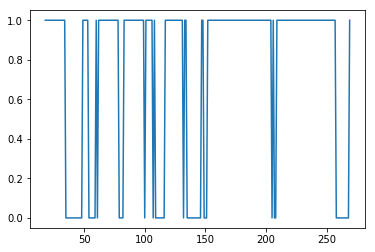

In [22]:
plt.plot(y_test)
# plt.axhline(0, color='black')

### Logistic Regression

In [56]:
def plotModelResults(model, X_train, X_test):
    
    if model == 'lgbm':
        prediction = (model.predict(X_test)*2-1 >= 0).astype('int8')
    elif model == 'model':
        prediction = (model.predict(X_test)*2-1 >= 0).astype('int8')
    else:
        prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

In [24]:
def evaluate(model, x_train, y_train, x_test, y_test):
    train_preds = model.predict(x_train)
    test_preds = model.predict(x_test)
    train_acc = metrics.accuracy_score(y_train, train_preds)
    test_acc = metrics.accuracy_score(y_test, test_preds)
    print('Train accuracy: %s' % train_acc)
    print('Test accuracy: %s' % test_acc)

In [25]:
def plot_feature(data, feature_name):
    plt.figure(figsize=(10, 3))
    plt.scatter(data[feature_name], y_train)
    plt.xlabel(feature_name)
    plt.ylabel('direction')
    plt.show()

# plot_feature(data_train, 'returnsPre10_lag_10_min')

In [26]:
from sklearn.linear_model import LogisticRegression
scaler = StandardScaler()

scaler.fit(data_train)
X_train_scaled = scaler.transform(data_train)
X_test_scaled = scaler.transform(data_test)

# scaler.fit(x_train)
# X_train_scaled = scaler.transform(x_train)
# X_test_scaled = scaler.transform(x_test)

clf = LogisticRegression().fit(X_train_scaled, y_train)

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [27]:
prediction = clf.predict(X_test_scaled)
prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [28]:
evaluate(clf, X_train_scaled, y_train, X_test_scaled, y_test)

Train accuracy: 0.6385165326184093
Test accuracy: 0.7420634920634921


In [29]:
# plotModelResults(clf, X_train_scaled, X_test_scaled)

We can see that the logistic regression model predict almost all-rising direction of the testing data. It is because the data itself is **imbalance**, causing the model only have to guess '1', and it will get a accuracy of around 0.64 on the training data. Let's see if other method can resolve this problem.

### Support Vector Machine

In [30]:
from sklearn.svm import SVC
penalty = 0.5

svm = SVC(C=penalty, probability=True)
svm.fit(X_train_scaled, y_train)

SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [31]:
# from sklearn.metrics import accuracy_score
# acc_rate = accuracy_score(y_test, svm.predict(X_test_scaled)) * 100
# print("Penalty = %.2f, Accuracy = %.2f %%" % (penalty, acc_rate))

In [32]:
prediction = svm.predict(X_test_scaled)
prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [33]:
# plotModelResults(svm, X_train_scaled, X_test_scaled)

In [34]:
evaluate(svm, X_train_scaled, y_train, X_test_scaled, y_test)

Train accuracy: 0.6416443252904379
Test accuracy: 0.7420634920634921


The result is as same as the logistic regression. 

### Neural Network
There are several tactics to deal with the imbalance data, one of them is set penalty to its weighting on the class which dominent the larger proportion. I will use this tactic in the NN approach.

In [35]:
hidden_units = 17    # how many neurons in the hidden layer
activation = 'relu'  # activation function for hidden layer
l2 = 0.001           # regularization - how much we penalize large parameter values
learning_rate = 0.01 # how big our steps are in gradient descent
epochs = 20          # how many epochs to train for
batch_size = 32      # how many samples to use for each gradient descent update

In [36]:
class_weight = {
    0: 1.,
    1: 809/1429 # there are 809 declines and 1429 rises
}

In [60]:
# create a sequential model
model = models.Sequential()

# add the hidden layer
model.add(layers.Dense(input_dim=17,
                       units=hidden_units, 
                       activation=activation))

model.add(layers.Dense(units=hidden_units, 
                       activation=activation))

# add the output layer
model.add(layers.Dense(input_dim=17,
                       units=1,
                       activation='sigmoid'))

# define our loss function and optimizer
model.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 17)                306       
_________________________________________________________________
dense_8 (Dense)              (None, 17)                306       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 18        
Total params: 630
Trainable params: 630
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
2238/2238 [==============================] - ETA: 33s - loss: 0.4470 - acc: 0.56 - ETA: 0s - loss: 0.5007 - acc: 0.5285 - ETA: 0s - loss: 0.5044 - acc: 0.513 - 1s 263us/step - loss: 0.5047 - acc: 0.5134
Epoch 2/50
2238/2238 [==============================] - ETA: 0s - loss: 0.5029 - acc: 0.531 - ETA: 0s - loss: 0.4851 - acc: 0.539 - 0s 47us/step - loss: 0.4889 - acc: 0.5532
Epoch 3/50
2238/2238 [==============================] - ETA: 0s - loss: 0.5005 - acc: 0.437 - ETA: 0s - loss: 0.4841 - acc: 0.544 - ETA: 0s - loss: 0.4849 - acc: 0.551 - 0s 58us/step - loss: 0.4867 - acc: 0.5523
Epoch 4/50
2238/2238 [==============================] - ETA: 0s - loss: 0.4474 - acc: 0.531 - ETA: 0s - loss: 0.4705 - acc: 0.590 - ETA: 0s - loss: 0.4772 - acc: 0.572 - 0s 54us/step - loss: 0.4798 - acc: 0.5697
Epoch 5/50
2238/2238 [==============================] - ETA: 0s - loss: 0.4608 - acc: 0.593 - ETA: 0s - loss: 0.4806 - acc: 0.570 - ETA: 0s - loss: 0.4751 - acc: 0.584 - 0s 52us/step - los

Epoch 46/50
2238/2238 [==============================] - ETA: 1s - loss: 0.3754 - acc: 0.812 - ETA: 0s - loss: 0.3606 - acc: 0.738 - 0s 35us/step - loss: 0.3604 - acc: 0.7382
Epoch 47/50
2238/2238 [==============================] - ETA: 0s - loss: 0.2911 - acc: 0.875 - ETA: 0s - loss: 0.3576 - acc: 0.743 - 0s 28us/step - loss: 0.3567 - acc: 0.7444
Epoch 48/50
2238/2238 [==============================] - ETA: 0s - loss: 0.4062 - acc: 0.781 - ETA: 0s - loss: 0.3487 - acc: 0.757 - 0s 39us/step - loss: 0.3508 - acc: 0.7542
Epoch 49/50
2238/2238 [==============================] - ETA: 0s - loss: 0.3246 - acc: 0.718 - ETA: 0s - loss: 0.3484 - acc: 0.748 - 0s 31us/step - loss: 0.3543 - acc: 0.7413
Epoch 50/50
252/252 [==============================] - ETA:  - 0s 28us/step
Training accuracy: 0.7743521000893655
Testing accuracy: 0.809523810469915


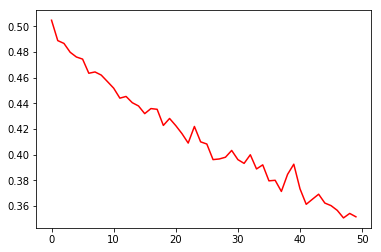

In [61]:
# train the parameters
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=batch_size, class_weight=class_weight)

# evaluate accuracy
train_acc = model.evaluate(X_train_scaled, y_train, batch_size=32)[1]
test_acc = model.evaluate(X_test_scaled, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

In [39]:
# pred = (model.predict(X_test_scaled)*2-1 >= 0).astype('int8')
train_preds = (model.predict(X_train_scaled)*2-1 >= 0).astype('int8')
test_preds = (model.predict(X_test_scaled)*2-1 >= 0).astype('int8')
train_acc = metrics.accuracy_score(y_train, train_preds)
test_acc = metrics.accuracy_score(y_test, test_preds)
print('Train accuracy: %s' % train_acc)
print('Test accuracy: %s' % test_acc)

Train accuracy: 0.788650580875782
Test accuracy: 0.7936507936507936


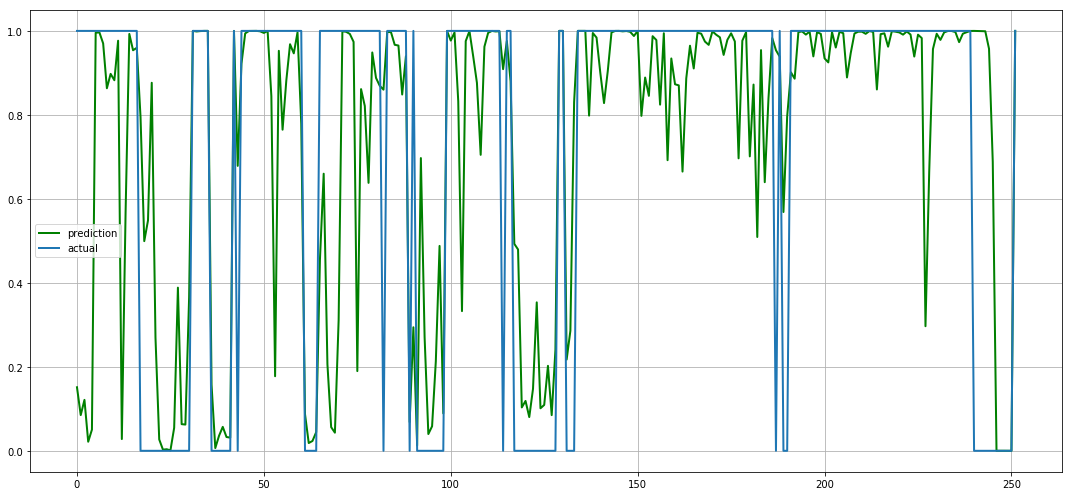

In [57]:
plotModelResults(model, X_train_scaled, X_test_scaled)

In [40]:
from tqdm import tqdm
def train_and_evaluate(model, x_train, y_train, x_test, y_test, n=20):
    train_accs = []
    test_accs = []
    with tqdm(total=n) as progress_bar:
        for _ in range(n):
            model.fit(
                x_train, 
                y_train, 
                epochs=epochs, 
                batch_size=batch_size, 
                class_weight=class_weight, 
                verbose=False)
            train_accs.append(model.evaluate(x_train, y_train, batch_size=32, verbose=False)[1])
            test_accs.append(model.evaluate(x_test, y_test, batch_size=32, verbose=False)[1])
            progress_bar.update()
    print('Avgerage Training Accuracy: %s' % np.average(train_accs))
    print('Avgerage Testing Accuracy: %s' % np.average(test_accs))
    return train_accs, test_accs

In [41]:
_, test_accs = train_and_evaluate(model, X_train_scaled, y_train, X_test_scaled, y_test)

100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


Avgerage Training Accuracy: 0.8380026809331879
Avgerage Testing Accuracy: 0.832738093960853


In [42]:
max(test_accs)

0.8690476190476191

### Try Other Models

In [43]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

train_data=lgb.Dataset(X_train_scaled,label=y_train)
valid_data=lgb.Dataset(X_test_scaled,label=y_test)

In [44]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'regression',
          'nthread': 4,
          'num_leaves': 34,
          'learning_rate': 0.005,
          'subsample': 0.8,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 1,
          'metric' : 'auc'
          }

In [45]:
lgbm = lgb.train(params,
                 train_data,
                 25000,
                 valid_sets=valid_data,
                 early_stopping_rounds= 40,
                 verbose_eval= 20
                 )

Training until validation scores don't improve for 40 rounds.
[20]	valid_0's auc: 0.826656
[40]	valid_0's auc: 0.823077
Early stopping, best iteration is:
[8]	valid_0's auc: 0.838091


In [46]:
train_preds = (lgbm.predict(X_train_scaled)*2-1 >= 0).astype('int8')
test_preds = (lgbm.predict(X_test_scaled)*2-1 >= 0).astype('int8')
train_acc = metrics.accuracy_score(y_train, train_preds)
test_acc = metrics.accuracy_score(y_test, test_preds)
print('Train accuracy: %s' % train_acc)
print('Test accuracy: %s' % test_acc)

Train accuracy: 0.6385165326184093
Test accuracy: 0.7420634920634921


In [47]:
prediction = lgbm.predict(X_test_scaled)*2-1
(prediction >= 0).astype('int8')

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

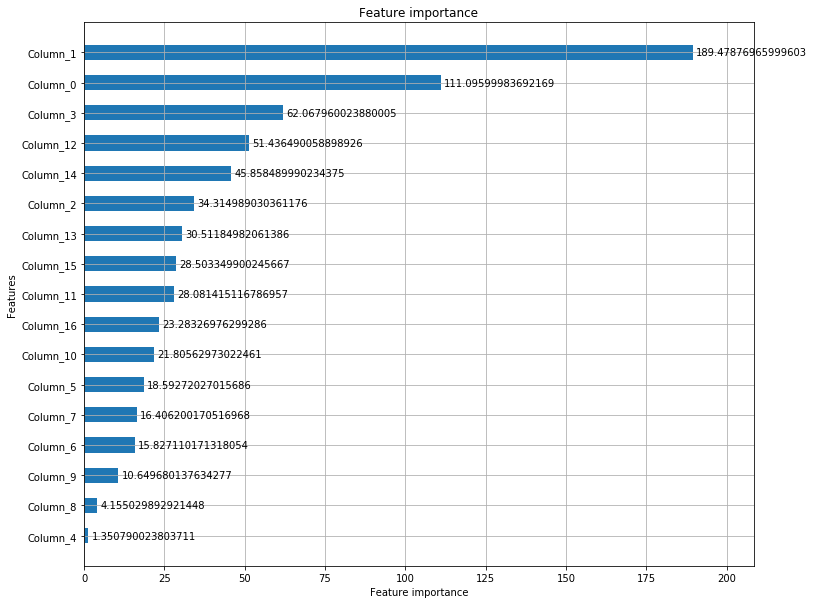

In [48]:
lgb.plot_importance(lgbm, height=0.5, ignore_zero = False, figsize = (12,10), importance_type ='gain')